In [ ]:
# API que permite acceder a modelos preentrenados
%pip install transformers 
# Procesamiento de datos
%pip install pandas 
# Detector de lenguaje en un texto
%pip install langdetect 
# Uso de expresiones regulares
%pip install regex 
# Librería para procesamiento de lenguaje natural
%pip install nltk 
# Libería para análisis de sentimiento
%pip install pysentimiento
# Librería para generar histogramas
%pip install matplotlib
# Librería para arreglos
%pip install numpy

In [ ]:
import nltk
import math
import langdetect
import regex as re
import numpy as np
import pandas as pd
from nltk import sentiment
import plotly.express as px
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
from transformers import pipeline
from pysentimiento import create_analyzer
from matplotlib.ticker import PercentFormatter 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [38]:
# Abstracción de código que permite usar un modelo para inferencia (transformer)
classifier = pipeline('zero-shot-classification') 
# Clasificador en español
classifier_es = pipeline("zero-shot-classification", 
                       model="Recognai/zeroshot_selectra_medium")
# Analizador de sentimientos (pysentimiento)
analyzer_en = create_analyzer(task="sentiment", lang="en")
# Analizador de sentimientos (NLTK)
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# No ejecutar esta celda, el resultado del preprocesado ya se encuentra en
# el archivo preprocessed_data.csv

# Se carga el dataset con Pandas
df = pd.read_csv('twitter_data.csv', lineterminator='\n')
df = df[['tweet']]

# Función que aplica un preprocesado básico en los tweets
# Quita saltos de línea, links, hashtags, arrobas y espacios extra
def preprocess(text):
    text = text.replace('\n', ' ')
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', '',text)
    text = re.sub('@[\w]+', '',text)
    re.sub("\s\s+", " ", text)
    if(str.isspace(text)):
        return ''
    return text

# Se aplica el preprocesado a cada tweet
df['tweet']= df['tweet'].apply(preprocess)

# Ya que hay unos tweets que quedan vacíos, porque se componían solo de hashtags,
# Se eliminan del dataframe
df['tweet'] = df['tweet'].replace('', np.nan)
df.dropna(inplace = True)

# Se exporta el dataframe preprocesado a un archivo csv
df.to_csv(path_or_buf='preprocessed_data.csv', columns = ['tweet'])

In [ ]:
# No ejecutar esta celda si no es necesario, su resultado es un nuevo csv 
# llamado tweets_eng_esp.csv que tiene una columna que almacena el
# lenguage de cada tweet. Solo se almacenan en inglés y español

# Entienda p_df como preprocessed_dataframe
p_df = pd.read_csv('preprocessed_data.csv', lineterminator='\n')

# Se crea una lista que contendrá el lenguaje detectado de cada texto
langs = []

# Función que identifica el lenguaje de un texto y adjunta el resultado a una lista
def get_langs(text):
    if len(langs) % 10000 == 0: print(len(langs))
    try:
        lang = langdetect.detect(text)
        if lang == 'en' or lang == 'es':
            langs.append(lang)
        else:
            langs.append('')
    except:
        langs.append('')

# Se aplica la identificación de lenguaje a cada tweet
p_df.rename(columns={"tweet\r": "tweet"}, inplace=True)
p_df['tweet'].apply(get_langs)

# Se insertan dichos lenguajes como una columna del DataSet
p_df.insert(1, 'lang', langs, allow_duplicates=True)

p_df['lang'] = p_df['lang'].replace('', np.nan)
p_df.dropna(inplace = True)
p_df.to_csv(path_or_buf='tweets_eng_esp.csv')

0


In [ ]:
df = pd.read_csv('tweets_eng_esp.csv', lineterminator='\n')

tweets_esp = df.loc[df['lang'] == 'es']
tweets_eng = df.loc[df['lang'] == 'en']

set1_esp = tweets_esp.iloc[0:99]['tweet\r'].values.tolist()
set2_esp = tweets_esp.iloc[100:199]['tweet\r'].values.tolist()
set3_esp = tweets_esp.iloc[200:299]['tweet\r'].values.tolist()
set4_esp = tweets_esp.iloc[300:399]['tweet\r'].values.tolist()

set1_eng = tweets_eng.iloc[0:99]['tweet\r'].values.tolist()
set2_eng = tweets_eng.iloc[100:199]['tweet\r'].values.tolist()
set3_eng = tweets_eng.iloc[200:299]['tweet\r'].values.tolist()
set4_eng = tweets_eng.iloc[300:399]['tweet\r'].values.tolist()

In [43]:
# Se clasifican los tweets por temas
candidate_labels = ['Trump']

In [45]:
output1_esp = classifier_es(set1_esp, candidate_labels, hypothesis_template='Habla de {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output1_esp = [elem for elem in output1_esp if elem['scores'][0] > 0.1]

In [46]:
output2_esp = classifier_es(set2_esp, candidate_labels, hypothesis_template='Habla sobre {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output2_esp = [elem for elem in output2_esp if elem['scores'][0] > 0.1]

In [47]:
output3_esp = classifier_es(set3_esp, candidate_labels, hypothesis_template='Habla sobre {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output3_esp = [elem for elem in output3_esp if elem['scores'][0] > 0.1]

In [48]:
output4_esp = classifier_es(set4_esp, candidate_labels, hypothesis_template='Habla sobre {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output4_esp = [elem for elem in output4_esp if elem['scores'][0] > 0.1]

In [49]:
output1_eng = classifier(set1_eng, candidate_labels, hypothesis_template='Talks about {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output1_eng = [elem for elem in output1_eng if elem['scores'][0] > 0.1]

In [54]:
output2_eng = classifier(set2_eng, candidate_labels, hypothesis_template='Talks about {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output2_eng = [elem for elem in output2_eng if elem['scores'][0] > 0.1]

In [58]:
output3_eng = classifier(set3_eng, candidate_labels, hypothesis_template='Talks about {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output3_eng = [elem for elem in output3_eng if elem['scores'][0] > 0.1]

In [55]:
output4_eng = classifier(set4_eng, candidate_labels, hypothesis_template='Talks about {}') # Recibe una entrada a clasificar y las etiquetas para un nuevo modelo
output4_eng = [elem for elem in output4_eng if elem['scores'][0] > 0.1]

In [34]:
# No correr esta línea, su resultado se encuentra en un csv: 'outputs_esp.csv'
# Se guardan los tweets que si hablan de Trump en un nuevo csv
d = {'output 1' : output1_esp, 'output 2' : output2_esp, 'output 3' : output3_esp, 'output 4' : output4_esp }
outputs_esp = pd.DataFrame(data=d)
outputs_esp.to_csv(path_or_buf='outputs_esp.csv')

In [35]:
# No correr esta línea, su resultado se encuentra en un csv: 'outputs_eng.csv'
# Se guardan los tweets que si hablan de Trump (en inglés) en un nuevo csv
d = {'output 1' : output1_eng, 'output 2' : output2_eng, 'output 3' : output3_eng, 'output 4' : output4_eng }
outputs_eng = pd.DataFrame(data=d)
outputs_eng.to_csv(path_or_buf='outputs_eng.csv')

In [37]:
outputs_esp = pd.read_csv('outputs_esp.csv')
output1_esp = outputs_esp['output 1'].values.tolist()
output2_esp = outputs_esp['output 2'].values.tolist()
output3_esp = outputs_esp['output 3'].values.tolist()
output4_esp = outputs_esp['output 4'].values.tolist()

sentiment_labels = ['desaprueba fuertemente', 'desaprueba', 'es neutral hacia', 'apoya', 'apoya fuertemente']
#sentiment_labels = ['Totalmente en contra', 'En contra', 'Neutral', 'A favor', 'Totalmente a favor']

histogram1_esp = sentiment_labels + []
histogram2_esp = sentiment_labels + []
histogram3_esp = sentiment_labels + []
histogram4_esp = sentiment_labels + []

results = []

hypothesis = 'Este mensaje {} la candidatura de Donald Trump para la presidencia.'

def histogram_maker(output, histogram):
    for tweet in output:
        analysis = classifier_es(tweet['sequence'], sentiment_labels, hypothesis_template=hypothesis)
        histogram.append(analysis['labels'][0])
        results.append(tweet['sequence'] + ' ' + analysis['labels'][0])

histogram_maker(output1_esp, histogram1_esp)
histogram_maker(output2_esp, histogram2_esp)
histogram_maker(output3_esp, histogram3_esp)
histogram_maker(output4_esp, histogram4_esp)

NameError: name 'classifier_es' is not defined

In [94]:
outputs_eng = pd.read_csv('outputs_eng.csv')
output1_eng = outputs_eng['output 1'].values.tolist()
output2_eng = outputs_eng['output 2'].values.tolist()
output3_eng = outputs_eng['output 3'].values.tolist()
output4_eng = outputs_eng['output 4'].values.tolist()

sentiment_labels = ['Strongly unsupport', 'Unupport', 'Neutral about', 'Support', 'Strongly support']

histogram1_eng = sentiment_labels + []
histogram2_eng = sentiment_labels + []
histogram3_eng = sentiment_labels + []
histogram4_eng = sentiment_labels + []

results_eng = []
hypothesis = '{} Trump'

def histogram_maker(output, histogram):
    for tweet in output:
        analysis = classifier_es(tweet['sequence'], sentiment_labels, hypothesis_template=hypothesis)
        histogram.append(analysis['labels'][0])
        results_eng.append(tweet['sequence'] + ' ' + analysis['labels'][0])

histogram_maker(output1_eng, histogram1_eng)
histogram_maker(output2_eng, histogram2_eng)
histogram_maker(output3_eng, histogram3_eng)
histogram_maker(output4_eng, histogram4_eng)

In [ ]:
# El primer histograma es el azul,  el segundo es el naranja, el tercero es el verde y el cuarto el rojo

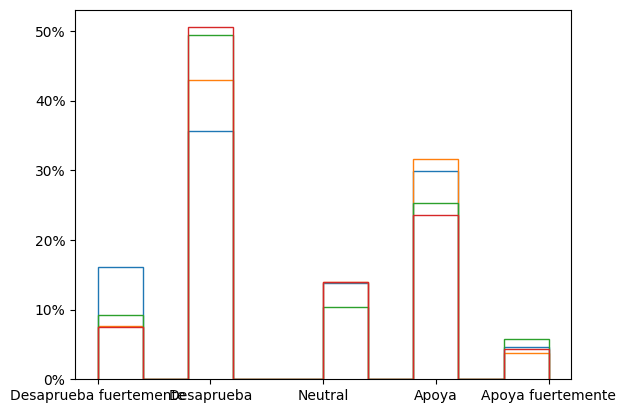

In [8]:
plt.hist(histogram1_esp, weights=np.ones(len(histogram1_esp)) / len(histogram1_esp), histtype='step')
plt.hist(histogram2_esp , weights=np.ones(len(histogram2_esp)) / len(histogram2_esp), histtype='step')
plt.hist(histogram3_esp , weights=np.ones(len(histogram3_esp)) / len(histogram3_esp), histtype='step')
plt.hist(histogram4_esp , weights=np.ones(len(histogram4_esp)) / len(histogram4_esp), histtype='step')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

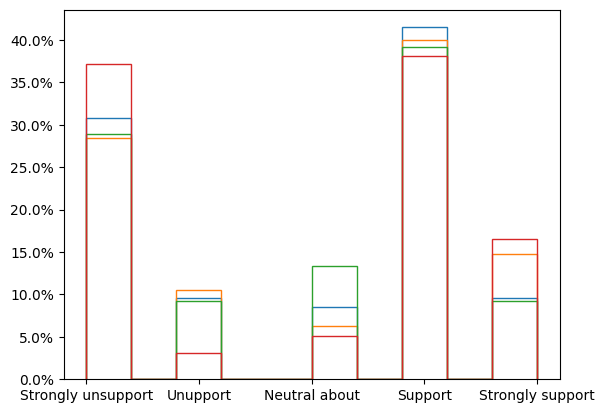

In [97]:
plt.hist(histogram1_eng, weights=np.ones(len(histogram1_eng)) / len(histogram1_eng), histtype='step')
plt.hist(histogram2_eng , weights=np.ones(len(histogram2_eng)) / len(histogram2_eng), histtype='step')
plt.hist(histogram3_eng , weights=np.ones(len(histogram3_eng)) / len(histogram3_eng), histtype='step')
plt.hist(histogram4_eng , weights=np.ones(len(histogram4_eng)) / len(histogram4_eng), histtype='step')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [108]:
%store -r histogram1_esp
%store -r histogram2_esp
%store -r histogram3_esp
%store -r histogram4_esp
%store -r results
%store -r histogram1_eng
%store -r histogram2_eng
%store -r histogram3_eng
%store -r histogram4_eng

for result in results:
    try:
        text = result.split('\r\n\r')
        tweet = text[0]
        opinion = text[1]
    except:
        text = result.split('\r')
        tweet = text[0]
        opinion = text[1]

    print('TWEET: ' + text[0])
    print('OPINION: ' + text[1] + '\n')

TWEET:      Otro jonrón de #Trump. 👊🏻Y que no se nos olvide que ahí también están involucrados los #ClintonCrimeFamily y #Obama, por mencionar algunos.  
OPINION:  Apoya

TWEET: Las campañas de #Biden en la comunidad latina literal es nomas el diciendo "Hola no soy #Trump vota por mi". 🤦🏻‍♂️
OPINION:  Neutral

TWEET: Si pierde #Trump ya verán como se acabará el calentamiento global, la opresión hacia los negros, las deportaciones, el machismo opresor, aparecerá la vacuna etc. Porque en realidad ese no es el problema, el problema es que no les gusta Trump.
OPINION:  Desaprueba

TWEET: #DonaldTrump afirma que se siente como “Superman” tras tomar Regeneron ►   
OPINION:  Desaprueba

TWEET: SALUD con TALA 114 ❤ COVID 19 Una Sindemia // Confinamiento dice la OMS // Regeneron la cura? Definen a la COVID-19 como una SINDEMIA Donald Trump         
OPINION:  Desaprueba

TWEET: #Barron , hijo menor de #Trump también contrajo el COVID-19   
OPINION:  Desaprueba

TWEET: #Economía Empresarios mexic